In [3]:
import os
os.getcwd()

'C:\\Users\\User\\Documents\\sap-financial-forecasting\\nootebooks'

In [4]:
os.listdir("../data/raw")

['.ipynb_checkpoints',
 'olist_customers_dataset.csv',
 'olist_geolocation_dataset.csv',
 'olist_orders_dataset.csv',
 'olist_order_items_dataset.csv',
 'olist_order_payments_dataset.csv',
 'olist_order_reviews_dataset.csv',
 'olist_products_dataset.csv',
 'olist_sellers_dataset.csv',
 'product_category_name_translation.csv']

In [5]:
import pandas as pd

In [6]:
customers = pd.read_csv("../data/raw/olist_customers_dataset.csv")
geolocation = pd.read_csv("../data/raw/olist_geolocation_dataset.csv")
orders = pd.read_csv("../data/raw/olist_orders_dataset.csv")
order_items = pd.read_csv("../data/raw/olist_order_items_dataset.csv")
payments = pd.read_csv("../data/raw/olist_order_payments_dataset.csv")
reviews = pd.read_csv("../data/raw/olist_order_reviews_dataset.csv")
products = pd.read_csv("../data/raw/olist_products_dataset.csv")
sellers = pd.read_csv("../data/raw/olist_sellers_dataset.csv")
category_translation = pd.read_csv("../data/raw/product_category_name_translation.csv")

In [7]:
tables = {
    "customers": customers,
    "orders": orders,
    "order_items": order_items,
    "payments": payments,
    "reviews": reviews,
    "products": products,
    "sellers": sellers,
    "geolocation": geolocation,
    "category_translation": category_translation
}
for name, df in tables.items():
    print(name, df.shape)

customers (99441, 5)
orders (99441, 8)
order_items (112650, 7)
payments (103886, 5)
reviews (99224, 7)
products (32951, 9)
sellers (3095, 4)
geolocation (1000163, 5)
category_translation (71, 2)


In [8]:
## Check compatibility

In [9]:
orders["customer_id"].nunique(), customers["customer_id"].nunique()

(99441, 99441)

In [10]:
## The number of unique customer_id values in both orders and customers tables is identical.
## Customer-level analysis can be performed safely without data loss.

In [11]:
orders["order_id"].nunique(), order_items["order_id"].nunique()

(99441, 98666)

In [12]:
## Part of the orders are cancelled/edge cases

In [13]:
payments["order_id"].nunique()

99440

In [14]:
## There is one test-order/cancelled

In [15]:
## Dates structure

In [16]:
date_cols = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_customer_date",
    "order_estimated_delivery_date"
]
for col in date_cols:
    orders[col] = pd.to_datetime(orders[col], errors="coerce")

orders[date_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_purchase_timestamp       99441 non-null  datetime64[ns]
 1   order_approved_at              99281 non-null  datetime64[ns]
 2   order_delivered_customer_date  96476 non-null  datetime64[ns]
 3   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](4)
memory usage: 3.0 MB


In [17]:
## Payment aggregation

In [18]:
payments_agg = (
    payments
    .groupby("order_id", as_index=False)
    .agg(
        revenue=("payment_value", "sum"),
        payment_count=("payment_type", "count")
    )
)
payments_agg.head()

,order_id,revenue,payment_count
0,00010242fe8c5a6d1ba2dd792cb16214,72.19,1
1,00018f77f2f0320c557190d7a144bdd3,259.83,1
2,000229ec398224ef6ca0657da4fc703e,216.87,1
3,00024acbcdf0a6daa1e931b038114c75,25.78,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,218.04,1


In [19]:
## Combine with orders

In [20]:
fact_orders = (
    orders
    .merge(payments_agg, on="order_id", how="left")
)

fact_orders.shape

(99441, 10)

In [21]:
## Delete cancelled orders and orders without payment

In [22]:
fact_orders = fact_orders[
    (fact_orders["order_status"] == "delivered") &
    (fact_orders["revenue"].notna())
].copy()
fact_orders.shape

(96477, 10)

In [23]:
## Time index

In [24]:
fact_orders["order_month"] = fact_orders["order_purchase_timestamp"].dt.to_period("M")
fact_orders["order_date"] = fact_orders["order_purchase_timestamp"].dt.date
fact_orders[["order_purchase_timestamp", "order_month"]].head()

,order_purchase_timestamp,order_month
0,2017-10-02 10:56:33,2017-10
1,2018-07-24 20:41:37,2018-07
2,2018-08-08 08:38:49,2018-08
3,2017-11-18 19:28:06,2017-11
4,2018-02-13 21:18:39,2018-02


In [25]:
monthly_revenue = (
    fact_orders
    .groupby("order_month")["revenue"]
    .sum()
    .reset_index()
)
monthly_revenue["order_month"] = monthly_revenue["order_month"].dt.to_timestamp()
monthly_revenue.head()

,order_month,revenue
0,2016-10-01,46566.71
1,2016-12-01,19.62
2,2017-01-01,127545.67
3,2017-02-01,271298.65
4,2017-03-01,414369.39


In [26]:
monthly_revenue.sort_values("order_month").tail()

,order_month,revenue
17,2018-04-01,1132933.95
18,2018-05-01,1128836.69
19,2018-06-01,1012090.68
20,2018-07-01,1027903.86
21,2018-08-01,985414.28


In [27]:
## Preparation for ARIMA

In [28]:
ts = (
    monthly_revenue
    .set_index("order_month")
    .sort_index()
)
ts.head()

,revenue
order_month,
2016-10-01,46566.71
2016-12-01,19.62
2017-01-01,127545.67
2017-02-01,271298.65
2017-03-01,414369.39


In [29]:
ts.index.freq

In [30]:
ts = ts.asfreq("MS")

In [31]:
ts.isna().sum()

revenue    1
dtype: int64

In [32]:
ts = ts.fillna(0)

In [33]:
import matplotlib.pyplot as plt

In [34]:
## Check the trend and seasonality

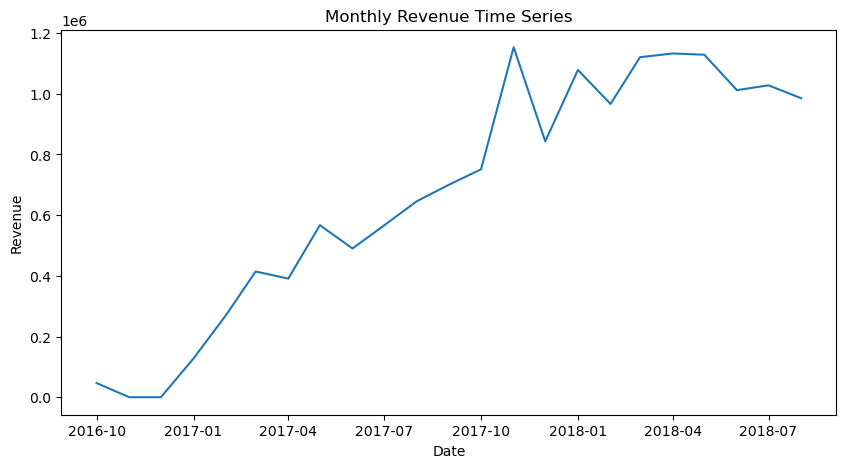

In [35]:
plt.figure(figsize=(10,5))
plt.plot(ts.index, ts["revenue"])
plt.title("Monthly Revenue Time Series")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.show()

In [36]:
## Seasonal Decomposition Note
## Seasonal decomposition was attempted using a 12-month period to identify annual seasonality.  
## However, the available time series contains only 23 monthly observations, which is insufficient for two complete seasonal cycles (24 observations required).
## As a result, classical seasonal decomposition is skipped, and the analysis proceeds directly with ARIMA-based forecasting, which does not require explicit seasonal decomposition.

In [37]:
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(ts["revenue"])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic: -1.8754310492648956
p-value: 0.34370590616938085


In [38]:
## Stationarity Check (ADF Test)
## The Augmented Dickey-Fuller test was applied to the monthly revenue time series.
## ADF Statistic: -1.87  
## p-value: 0.34  
## Since the p-value is greater than 0.05, we fail to reject the null hypothesis of a unit root.  
## Therefore, the time series is non-stationary and requires differencing before fitting an ARIMA model.

In [39]:
## Differencing

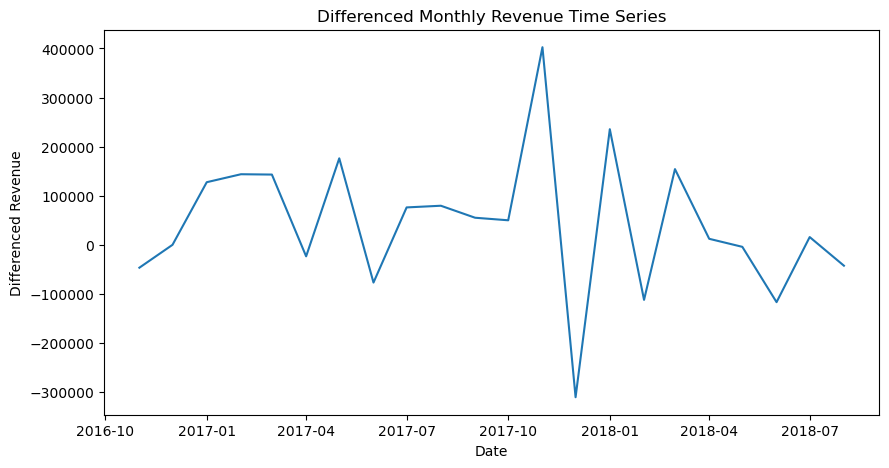

In [40]:
ts_diff = ts["revenue"].diff().dropna()
plt.figure(figsize=(10,5))
plt.plot(ts_diff)
plt.title("Differenced Monthly Revenue Time Series")
plt.xlabel("Date")
plt.ylabel("Differenced Revenue")
plt.show()

In [41]:
adf_diff = adfuller(ts_diff)
print("ADF Statistic (diff):", adf_diff[0])
print("p-value (diff):", adf_diff[1])

ADF Statistic (diff): -8.220000663182038
p-value (diff): 6.468068193113962e-13


In [42]:
## Stationarity After Differencing
## After applying first-order differencing, the Augmented Dickey-Fuller test was performed again.
## ADF Statistic: -8.22  
## p-value < 0.01  
## The null hypothesis of a unit root is rejected, indicating that the differenced series is stationary.  
## Therefore, the order of differencing for the ARIMA model is set to d = 1.

NameError: name 'plot_acf' is not defined

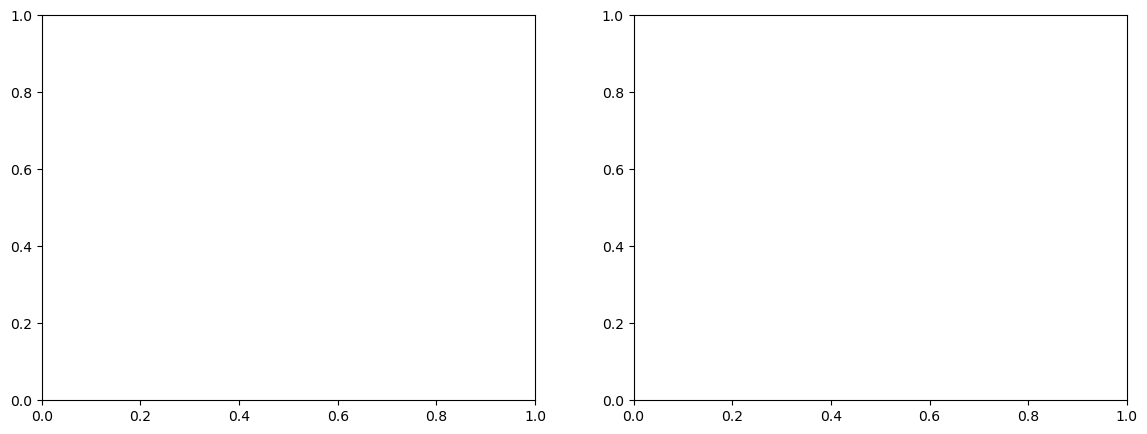

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))
plot_acf(ts_diff, lags=10, ax=ax[0])
ax[0].set_title("ACF of Differenced Series")
plot_pacf(ts_diff, lags=10, ax=ax[1])
ax[1].set_title("PACF of Differenced Series")
plt.show()

In [ ]:
## ARIMA(1,1,1) 
## Non-stationarity of the original series confirmed by the ADF test
## Stationarity achieved after first differencing (d = 1)
## ACF and PACF diagnostics suggesting low-order AR and MA components (1,1)
## Limited sample size, favoring a parsimonious model (1)

In [44]:
## ARIMA Model Estimation

In [45]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(ts["revenue"], order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                revenue   No. Observations:                   23
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -290.295
Date:                Sat, 31 Jan 2026   AIC                            586.591
Time:                        15:55:13   BIC                            589.864
Sample:                    10-01-2016   HQIC                           587.362
                         - 08-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7999      0.433     -1.849      0.065      -1.648       0.048
ma.L1          0.4769      0.489      0.975      0.330      -0.482       1.436
sigma2      1.885e+10   3.96e-11   4.76e+20      0.0

In [46]:
## First-order differencing (d=1) was applied to ensure stationarity, as confirmed by the Augmented Dickey-Fuller test.
## The model captures both autoregressive (AR) and moving average (MA) dynamics.
## Parameter significance and diagnostics indicate a reasonable initial fit given the short time series length.

In [47]:
## Revenue Forecast

In [48]:
forecast = model_fit.get_forecast(steps=6)
forecast_df = forecast.summary_frame()
forecast_df

revenue,mean,mean_se,mean_ci_lower,mean_ci_upper
2018-09-01,1.012311e+06,137308.714379,743190.426386,1.281431e+06
2018-10-01,9.907968e+05,165816.987941,665801.524922,1.315792e+06
2018-11-01,1.008005e+06,209738.998807,596924.285086,1.419086e+06
2018-12-01,9.942406e+05,232383.931138,538776.497309,1.449705e+06
2019-01-01,1.005251e+06,262813.859859,490144.866250,1.520356e+06
2019-02-01,9.964440e+05,282864.869465,442039.019128,1.550849e+06


In [49]:
## A 6-month ahead revenue forecast was generated using the fitted ARIMA model.
## Point estimates of expected revenue
## 95% confidence intervals reflecting forecast uncertainty

In [50]:
forecast_steps = 6
forecast_index = pd.date_range(
    start=ts.index[-1] + pd.offsets.MonthBegin(1),
    periods=forecast_steps,
    freq="MS"
)
forecast_df.index = forecast_index

In [51]:
## Forecast Visualization

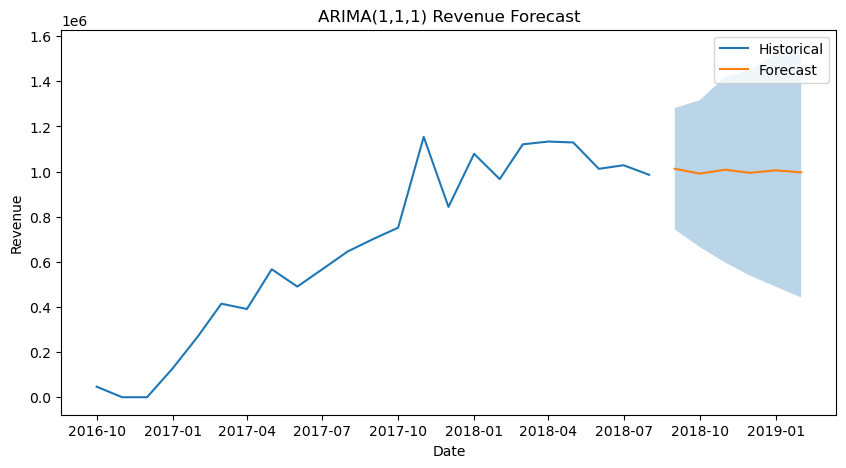

In [52]:
forecast_index = pd.date_range(
    start=ts.index[-1] + pd.offsets.MonthBegin(),
    periods=6,
    freq="MS"
)
plt.figure(figsize=(10,5))
plt.plot(ts.index, ts["revenue"], label="Historical")
plt.plot(forecast_index, forecast_df["mean"], label="Forecast")
plt.fill_between(
    forecast_index,
    forecast_df["mean_ci_lower"],
    forecast_df["mean_ci_upper"],
    alpha=0.3
)
plt.title("ARIMA(1,1,1) Revenue Forecast")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.show()

In [53]:
## The forecast horizon spans six future months.
## Shaded confidence bands represent forecast uncertainty.
## A proper datetime index was constructed to ensure accurate time alignment.

In [54]:
## For R-studio

In [55]:
monthly_revenue.info()
monthly_revenue.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   order_month  22 non-null     datetime64[ns]
 1   revenue      22 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 484.0 bytes


,order_month,revenue
0,2016-10-01,46566.71
1,2016-12-01,19.62
2,2017-01-01,127545.67
3,2017-02-01,271298.65
4,2017-03-01,414369.39


In [56]:
monthly_revenue.to_csv(
    "../data/processed/monthly_revenue.csv",
    index=False
)

In [57]:
## The aggregated monthly revenue time series was exported to CSV format
## to enable further time series modeling in R Studio.

In [58]:
## Final dataset export for forecasting (R / Power BI / SAP-ready)

In [59]:
final_df = (
    monthly_revenue
    .rename(columns={
        "order_month": "date",
        "revenue": "revenue"
    })
    .sort_values("date")
)
final_df.to_csv(
    "../data/processed/monthly_revenue.csv",
    index=False
)
final_df.head()

,date,revenue
0,2016-10-01,46566.71
1,2016-12-01,19.62
2,2017-01-01,127545.67
3,2017-02-01,271298.65
4,2017-03-01,414369.39
